# 8.1 Transfer Learning

In [ ]:
import torch
import torchvision 
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import numpy as np
from tqdm.auto import tqdm
from torch.utils.data.dataloader import default_collate
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# constants
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 32

We use the CIFAR10 dataset.

In [ ]:
transform = transforms.Compose(
    [
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) # CIFAR10 image statistics I found on the web.
    ]
)

In [ ]:
train_ds = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
train_ds = torch.utils.data.Subset(train_ds, list(range(0, len(train_ds)//4)))

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE,
                                          shuffle=True)

val_ds = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
val_ds = torch.utils.data.Subset(train_ds, list(range(0, len(val_ds)//4)))

val_loader = torch.utils.data.DataLoader(val_ds, batch_size=BATCH_SIZE,
                                         shuffle=False)

classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
dataloaders = {'train': train_loader, 'val': val_loader}

Data preparation is done. Let's use a pretrained resnet18 model for transfer learning.

In [ ]:
model = torchvision.models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

First we freeze all the layers except the linear layer (which we add ourselves) which will use the features to predict one of our 10 classes. In the first phase of transfer learning, we will only train this layer.

In [ ]:
for param in model.parameters():
    param.requires_grad = False # freeze first

In [ ]:
model.fc = nn.Linear(model.fc.in_features,len(classes))

In [ ]:
model.to(device)

print("moved to ", device)

moved to  cuda:0


In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=4e-4)

In [ ]:
def train_model(dataloaders, model, optim, loss_fn, num_epochs, device):
    train_loss_hist = []
    val_loss_hist = []
    val_acc = []
    min_val_loss = np.inf
    
    for epoch in tqdm(range(num_epochs)):
        for phase in ['train','val']:
            running_loss = 0.0
            running_acc = 0.0
            progress = 0

            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            for x, y in tqdm(dataloaders[phase]):
                x = x.to(device)
                y = y.to(device)

                out = model(x)
                loss = loss_fn(out, y)
                
                optim.zero_grad()

                running_loss += loss.item() * x.size(0)

                if phase == 'train':
                    loss.backward()
                    optim.step()
                else:
                    _, preds = torch.max(out, 1) # N x 1
                    running_acc += torch.sum(preds == y).item()

            epoch_loss = running_loss / len(dataloaders[phase].dataset)

            if phase == 'train':
                train_loss_hist.append(epoch_loss)
            else:
                epoch_acc = running_acc / len(dataloaders[phase].dataset)
                val_loss_hist.append(epoch_loss)
                val_acc.append(epoch_acc)
                if epoch_loss < min_val_loss:
                    min_val_loss = epoch_loss
                    torch.save(model.state_dict(), 'saved_model.pth')

        print(f'epoch {epoch+1} \t\t train_loss: {train_loss_hist[-1]} \t\t val_loss: {val_loss_hist[-1]} \t\t val_acc: {val_acc[-1]}')

      
    return train_loss_hist, val_loss_hist, val_acc

In [ ]:
train_loss_hist, val_loss_hist, val_acc = train_model(dataloaders, model, optimizer, loss_fn,  num_epochs = 4, device=device)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

epoch 1 		 train_loss: 0.7816726740646363 		 val_loss: 0.657333632183075 		 val_acc: 0.7852


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

epoch 2 		 train_loss: 0.7001722753715515 		 val_loss: 0.6094702236175538 		 val_acc: 0.7964


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

epoch 3 		 train_loss: 0.6696189536285401 		 val_loss: 0.5831623593330383 		 val_acc: 0.8108


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

epoch 4 		 train_loss: 0.6470094114685059 		 val_loss: 0.5556575140476226 		 val_acc: 0.8112


Now we unfreeze all the layers and train again, with a much lower learning rate.

In [ ]:
for param in model.parameters():
    param.requires_grad = True # freeze first

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
train_loss_hist, val_loss_hist, val_acc = train_model(dataloaders, model, optimizer, loss_fn,  num_epochs = 6, device=device)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

epoch 1 		 train_loss: 0.5133861240386963 		 val_loss: 0.3378998291492462 		 val_acc: 0.8816


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

epoch 2 		 train_loss: 0.36266476534843445 		 val_loss: 0.257971150302887 		 val_acc: 0.9216


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

epoch 3 		 train_loss: 0.296355796456337 		 val_loss: 0.1876681697845459 		 val_acc: 0.9456


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

epoch 4 		 train_loss: 0.24738186275482177 		 val_loss: 0.152142038333416 		 val_acc: 0.9604


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

epoch 5 		 train_loss: 0.21294071670532227 		 val_loss: 0.1378575355052948 		 val_acc: 0.9652


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

epoch 6 		 train_loss: 0.1840294529914856 		 val_loss: 0.10843447284102439 		 val_acc: 0.9804


In the end, we got a validation accuracy of 98%. Can you reach a higher accuracy than what we have here? 

Let's also visualise our predictions.

In [ ]:
# We have to de-normalize the images so they display correctly when calling imshow()
inv = transforms.Normalize(
    mean=[-0.4914/0.2023, -0.4822/0.1994, -0.4465/0.2010],
    std=[1/0.2023, 1/0.1994, 1/0.2010]
)

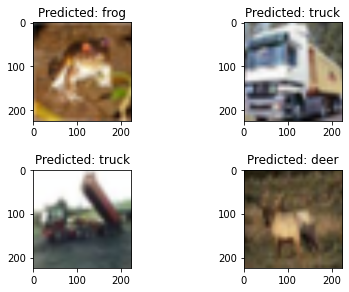

In [ ]:
dl_iter = iter(val_loader)
fig, axs = plt.subplots(2, 2)
fig.tight_layout()
fig.subplots_adjust(hspace=.5)
xs, ys = next(dl_iter)

for i in range(4):
  x = xs[i][None,...]
  y = ys[i][None,...]
  x = x.to(device)
  y = y.to(device)
  out = model(x)
  _, preds = torch.max(out, 1)
  img = inv(x).squeeze().cpu().permute(1,2,0) # matplotlib expects channel dimension to come last
  pred_label = classes[preds[0]]
  preds = preds.cpu().numpy()
  r,c = i // 2, i % 2
  axs[r,c].set_title(f'Predicted: {pred_label}')
  axs[r,c].imshow(img)

plt.show()